## 简介
- 输入.npy文件
- 输出其中图片标记车道直线后的新图片

In [212]:
import numpy as np
import pandas as pd
from collections import Counter
import cv2
import matplotlib.pyplot as plt

## 读取数据并整理标签

In [213]:
data = np.load('../Data/training_data-1.npy')
data_df = pd.DataFrame(data)
data_X = data_df[0]
data_Y = data_df[1]

In [214]:
direction_dict = {
 '[0, 0, 0, 0, 0, 0, 0, 0, 0]': 'default',
 '[0, 0, 0, 0, 0, 0, 0, 0, 1]': 'NK',
 '[0, 0, 0, 0, 0, 0, 0, 1, 0]': 'SD',
 '[0, 0, 0, 0, 0, 0, 1, 0, 0]': 'SA',
 '[0, 0, 0, 0, 0, 1, 0, 0, 0]': 'WD',
 '[0, 0, 0, 0, 1, 0, 0, 0, 0]': 'WA',
 '[0, 0, 0, 1, 0, 0, 0, 0, 0]': 'D',
 '[0, 0, 1, 0, 0, 0, 0, 0, 0]': 'A',
 '[0, 1, 0, 0, 0, 0, 0, 0, 0]': 'S',
 '[1, 0, 0, 0, 0, 0, 0, 0, 0]': 'W'
}

data_df[1] = data_df[1].apply(str).map(direction_dict)                  # 更改data_df
data_Y = data_Y.apply(str).map(direction_dict)                          # 更改data_Y

data_df.head()

,0,1
0,"[[[238, 204, 171], [246, 231, 216], [69, 55, 4...",W
1,"[[[238, 204, 171], [246, 231, 216], [69, 57, 4...",W
2,"[[[238, 204, 171], [246, 231, 216], [69, 55, 4...",WA
3,"[[[238, 204, 171], [246, 231, 216], [63, 51, 3...",WD
4,"[[[238, 204, 171], [246, 231, 216], [91, 90, 8...",WA


In [215]:
X = data_X.copy()
Y = data_Y.copy()

## 自定义方法

- 处理图片需要 多边形填充 获得平滑的处理图片
- 计算车道
    - 查找可能的线段
    - 以近似斜率分组线段，返回各组总长度前三的的近似车道
    - 融合近似车道
- 比较展示：
    - 可能线段图 和 融合近似车道图

In [216]:
# 用vertices多边形填充img
def roi(img, vertices):
    mask = np.zeros_like(img)
    cv2.fillPoly(mask, vertices, 255)
    masked = cv2.bitwise_and(img, mask)
    return masked

In [217]:
# 处理图片并标记图片中车道并返回两者
def get_processed_img_lane(rgb_image):
    # 单色新图片
    processed_img = cv2.Canny(rgb_image, threshold1=200, threshold2=300)       # 阈值为（200，300）的选区区域
    processed_img = cv2.GaussianBlur(processed_img, (3,3), 0 )                 # 高斯滤波 
    
    vertices = np.array([[0,200],[0,0],[800,0],[800,200]], np.int32)           # 多边形
    processed_img = roi(processed_img, [vertices])                             # 多边形填充

    lines = cv2.HoughLinesP(processed_img, 1, np.pi/180, 120, 20, 35)          # 霍夫查找
    return processed_img, lines

In [218]:
# 从多个[m,b,lineCoordList]的列表lane_data计算平均坐标（融合每组近似车道）
def average_lane(lane_data):
    x1s = []
    y1s = []
    x2s = []
    y2s = []
    for data in lane_data:
        x1s.append(data[2][0])
        y1s.append(data[2][1])
        x2s.append(data[2][2])
        y2s.append(data[2][3])
    return [int(np.mean(x1s)), int(np.mean(y1s)), int(np.mean(x2s)), int(np.mean(y2s))]

In [219]:
# 找出标记边界的图片中车道lanes(最长的三条)
def find_main_lanes(img, lines, color=[0, 255, 255], thickness=3):
    """
    1.位移多线段，方便比较和融合
    2.组合多线段
    3.获取组合后的总线段长度前三，视为近似车道
    4.分别融合每组近似车道
    """
    ## 1.根据lines中的点，用最小二乘法确定回归方向，使各个线段位于固定Y值范围内
    ys = []  
    for i in lines:
        for ii in i:
            ys += [ii[1],ii[3]]
    min_y = min(ys)
    max_y = 270 # HEIGHT
    mid_y = 200
    
    new_lines = []                                                   
    line_dict = {}

    for idx,i in enumerate(lines):
        for xyxy in i:
            x_coords = (xyxy[0],xyxy[2])
            y_coords = (xyxy[1],xyxy[3])
            A = np.vstack([x_coords,np.ones(len(x_coords))]).T
            m, b = np.linalg.lstsq(A, y_coords, rcond=None)[0]

            # 计算位移到固定Y值范围内的X值
            x1 = (min_y-b) / m
            x2 = (max_y-b) / m

            line_dict[idx] = [m,b,[int(x1), min_y, int(x2), max_y]]
            new_lines.append([int(x1), min_y, int(x2), max_y])
    
    
    
    ## 查找最终的车道（组合相似的线段，以斜率m为索引存储）
    final_lanes = {}
    found_copy = True
    top_rate = 1.2
    bnt_rate = 2-top_rate

    # 确定图中某条线代表的方向，根据某方向线段数量确定权重
    for idx  in line_dict:
        final_lanes_copy = final_lanes.copy()                    # 保存增加前的final_lanes
        m = line_dict[idx][0]
        b = line_dict[idx][1]
        line = line_dict[idx][2]

        if len(final_lanes) == 0:
            final_lanes[m] = [ [m,b,line] ]                     # 方向（斜率m）作为索引

        else:
            found_copy = False

            for other_ms in final_lanes_copy:
                # 没发现可复制的lanes
                if not found_copy:
                    # 线段相似度处于一定比例
                    if abs(other_ms*top_rate) > abs(m) > abs(other_ms*bnt_rate):     # 当前斜率m与其他斜率差别处于一定比例
                        if abs(final_lanes_copy[other_ms][0][1]*top_rate) > abs(b) > abs(final_lanes_copy[other_ms][0][1]*bnt_rate):  
                        # 当前截距b与其他截距差别处于一定比例
                            final_lanes[other_ms].append([m,b,line])
                            found_copy = True
                            break
                    else:
                        final_lanes[m] = [ [m,b,line] ]
                        
                        
    
    ## 按长度排列（大到小）lanes，并返回
    line_counter = {}                                                            # 统计每个lanes的长度

    for lanes in final_lanes:
        line_counter[lanes] = len(final_lanes[lanes])

    top_lanes = sorted(line_counter.items(), key=lambda item: item[1])[::-1]    # 按字典值（lanes长度）大到小排列的列表
    

#     print('top_lanes', len(top_lanes))
    # lanes长度前三的索引（斜率）
    lane1_id = top_lanes[0][0]
    lane2_id = top_lanes[1][0]
    lane3_id = top_lanes[2][0]
    
#     print(final_lanes[3.432192872032214e-16])
    
    # 长度前三的lanes， 融合成一条线
    l1 = average_lane(final_lanes[lane1_id])
    l2 = average_lane(final_lanes[lane2_id])
    l3 = average_lane(final_lanes[lane3_id])

    return l1,l2,l3

In [220]:
# 获得已画出车道的图片和画出多线段的图片
def display_lanes(original_image):
    processed_img, lines = get_processed_img_lane(original_image)
    
    l1,l2,l3 = find_main_lanes(original_image,lines)                         # 最可能的三条车道
    
    # 在original_image上画出找到的车道（3条）
    cv2.line(original_image, (l1[0], l1[1]), (l1[2], l1[3]), [0,255,0], 10)
    cv2.line(original_image, (l2[0], l2[1]), (l2[2], l2[3]), [0,255,0], 10)
    cv2.line(original_image, (l3[0], l3[1]), (l3[2], l3[3]), [0,255,0], 10)
    
    
    # img图片中划线（多线段）
    for coords in lines:
        coords = coords[0]
        cv2.line(processed_img, (coords[0], coords[1]), (coords[2], coords[3]), [255,0,0], 3)
#     print('finish')
    return original_image, processed_img

## 展示单张标记车道图片

In [221]:
single_idx = 50
original_image, action = X.copy()[single_idx], Y.copy()[single_idx]
print('original_image', original_image.shape)
processed_img, lines = get_processed_img_lane(original_image)                     # 标记边界的图片，边界
print('processed_img',processed_img.shape)

original_image (270, 480, 3)
processed_img (270, 480)


org_screen (270, 480, 3)
org_screen (270, 480)


(<matplotlib.axes._subplots.AxesSubplot at 0x58b512e8>,
 Text(0.5, 1.0, 'new_screen'),
 (-0.5, 479.5, 269.5, -0.5))

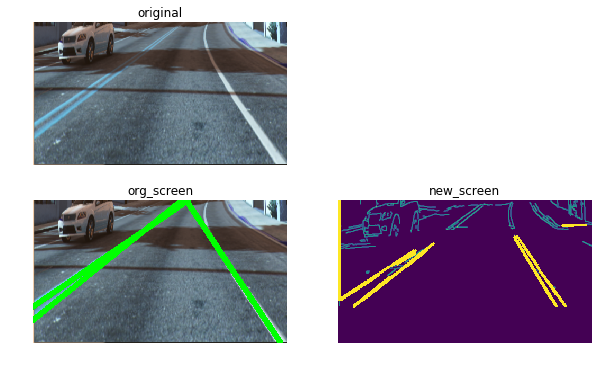

In [222]:
plt.figure(figsize=(10,6))
plt.subplot(221), plt.imshow(original_image), plt.title('original'), plt.axis("off")


org_screen, new_screen= display_lanes(original_image)                           # 获得画出车道和画出多线段的图片
print('org_screen',org_screen.shape)
print('org_screen',new_screen.shape)

plt.subplot(223), plt.imshow(org_screen), plt.title('org_screen'), plt.axis("off")
plt.subplot(224), plt.imshow(new_screen), plt.title('new_screen'), plt.axis("off")

In [223]:
processed_img, lines = 0, 0

## 批量标记车道并输出
```python
'./Graph/%d.png'%idx
```

In [235]:
err_list = []
for idx in range(len(X)):
    try:
        original_image, action = X[idx], Y[idx]

        org_screen, new_screen= display_lanes(original_image)                           # 获得画出车道和画出多线段的图片
        
        ok = cv2.imwrite('../Graph/%d_painted.png'%idx, org_screen)
    except OverflowError as ofe:
        err_list.append(idx)
        print(idx, ofe)

D:\setup_space_all\python3.6.6\lib\site-packages\ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in double_scalars
D:\setup_space_all\python3.6.6\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: divide by zero encountered in double_scalars


23 cannot convert float infinity to integer
35 cannot convert float infinity to integer
50 Python int too large to convert to C long
69 cannot convert float infinity to integer
74 cannot convert float infinity to integer
84 cannot convert float infinity to integer
85 cannot convert float infinity to integer
89 cannot convert float infinity to integer
92 cannot convert float infinity to integer
97 cannot convert float infinity to integer
101 cannot convert float infinity to integer
129 cannot convert float infinity to integer
131 cannot convert float infinity to integer
141 cannot convert float infinity to integer
146 cannot convert float infinity to integer
154 cannot convert float infinity to integer
169 cannot convert float infinity to integer
184 cannot convert float infinity to integer
188 cannot convert float infinity to integer
192 cannot convert float infinity to integer
193 cannot convert float infinity to integer
195 cannot convert float infinity to integer
202 cannot convert 

IndexError: list index out of range

In [230]:
"""
[50,85,89,97,129,131,146,154,169,170,184,188, 192,202,205,242,246,248,488,536]
"""
err_list


[14,
 23,
 35,
 69,
 74,
 85,
 89,
 92,
 97,
 129,
 131,
 146,
 154,
 169,
 184,
 188,
 192,
 193,
 195,
 202,
 204,
 205,
 217,
 221,
 222,
 223,
 229,
 230,
 231,
 234,
 241,
 242,
 246,
 248]